<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary modules
!pip install yfinance
!pip install plotly==5.2.1
!pip install ta
!pip install mplfinance

     |████████████████████████████████| 6.4 MB 6.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 21.8 MB 4.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=9c529bb5cd1e50c7d0e57941bb3a89edea26ba52ff94ca0b72d999fe9d432aeb
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta
     |████████████████████████████████| 64 kB 1.6 MB/s 


In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import requests
from bs4 import BeautifulSoup
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

In [11]:
ticker = yf.Ticker("TSLA")
ticker.splits
#historical = ticker.history(start="2020-02-05", end="2020-02-25", interval="1d")
#historical

Date
2020-08-31    5.0
Name: Stock Splits, dtype: float64

In [12]:
# method 1: fractal candlestick pattern

def get_stock_price(symbol):
  #df = yf.download(symbol, start='2020-01-01')
  #df = df.rename(columns={"Close": "Close1", "Adj Close": "Close"})
  
  ticker = yf.Ticker(symbol)
  #ticker.splits
  df = ticker.history(start="2021-01-01", interval="1d")
  #print(df.info())
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0

def plot_all(levels, df):
    fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    for level in levels:
        plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linestyle='--')
    fig.show()


def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    #options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    #options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2021-01-04 to 2021-12-13
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          239 non-null    float64
 1   High          239 non-null    float64
 2   Low           239 non-null    float64
 3   Close         239 non-null    float64
 4   Volume        239 non-null    int64  
 5   Dividends     239 non-null    int64  
 6   Stock Splits  239 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 14.9 KB
None


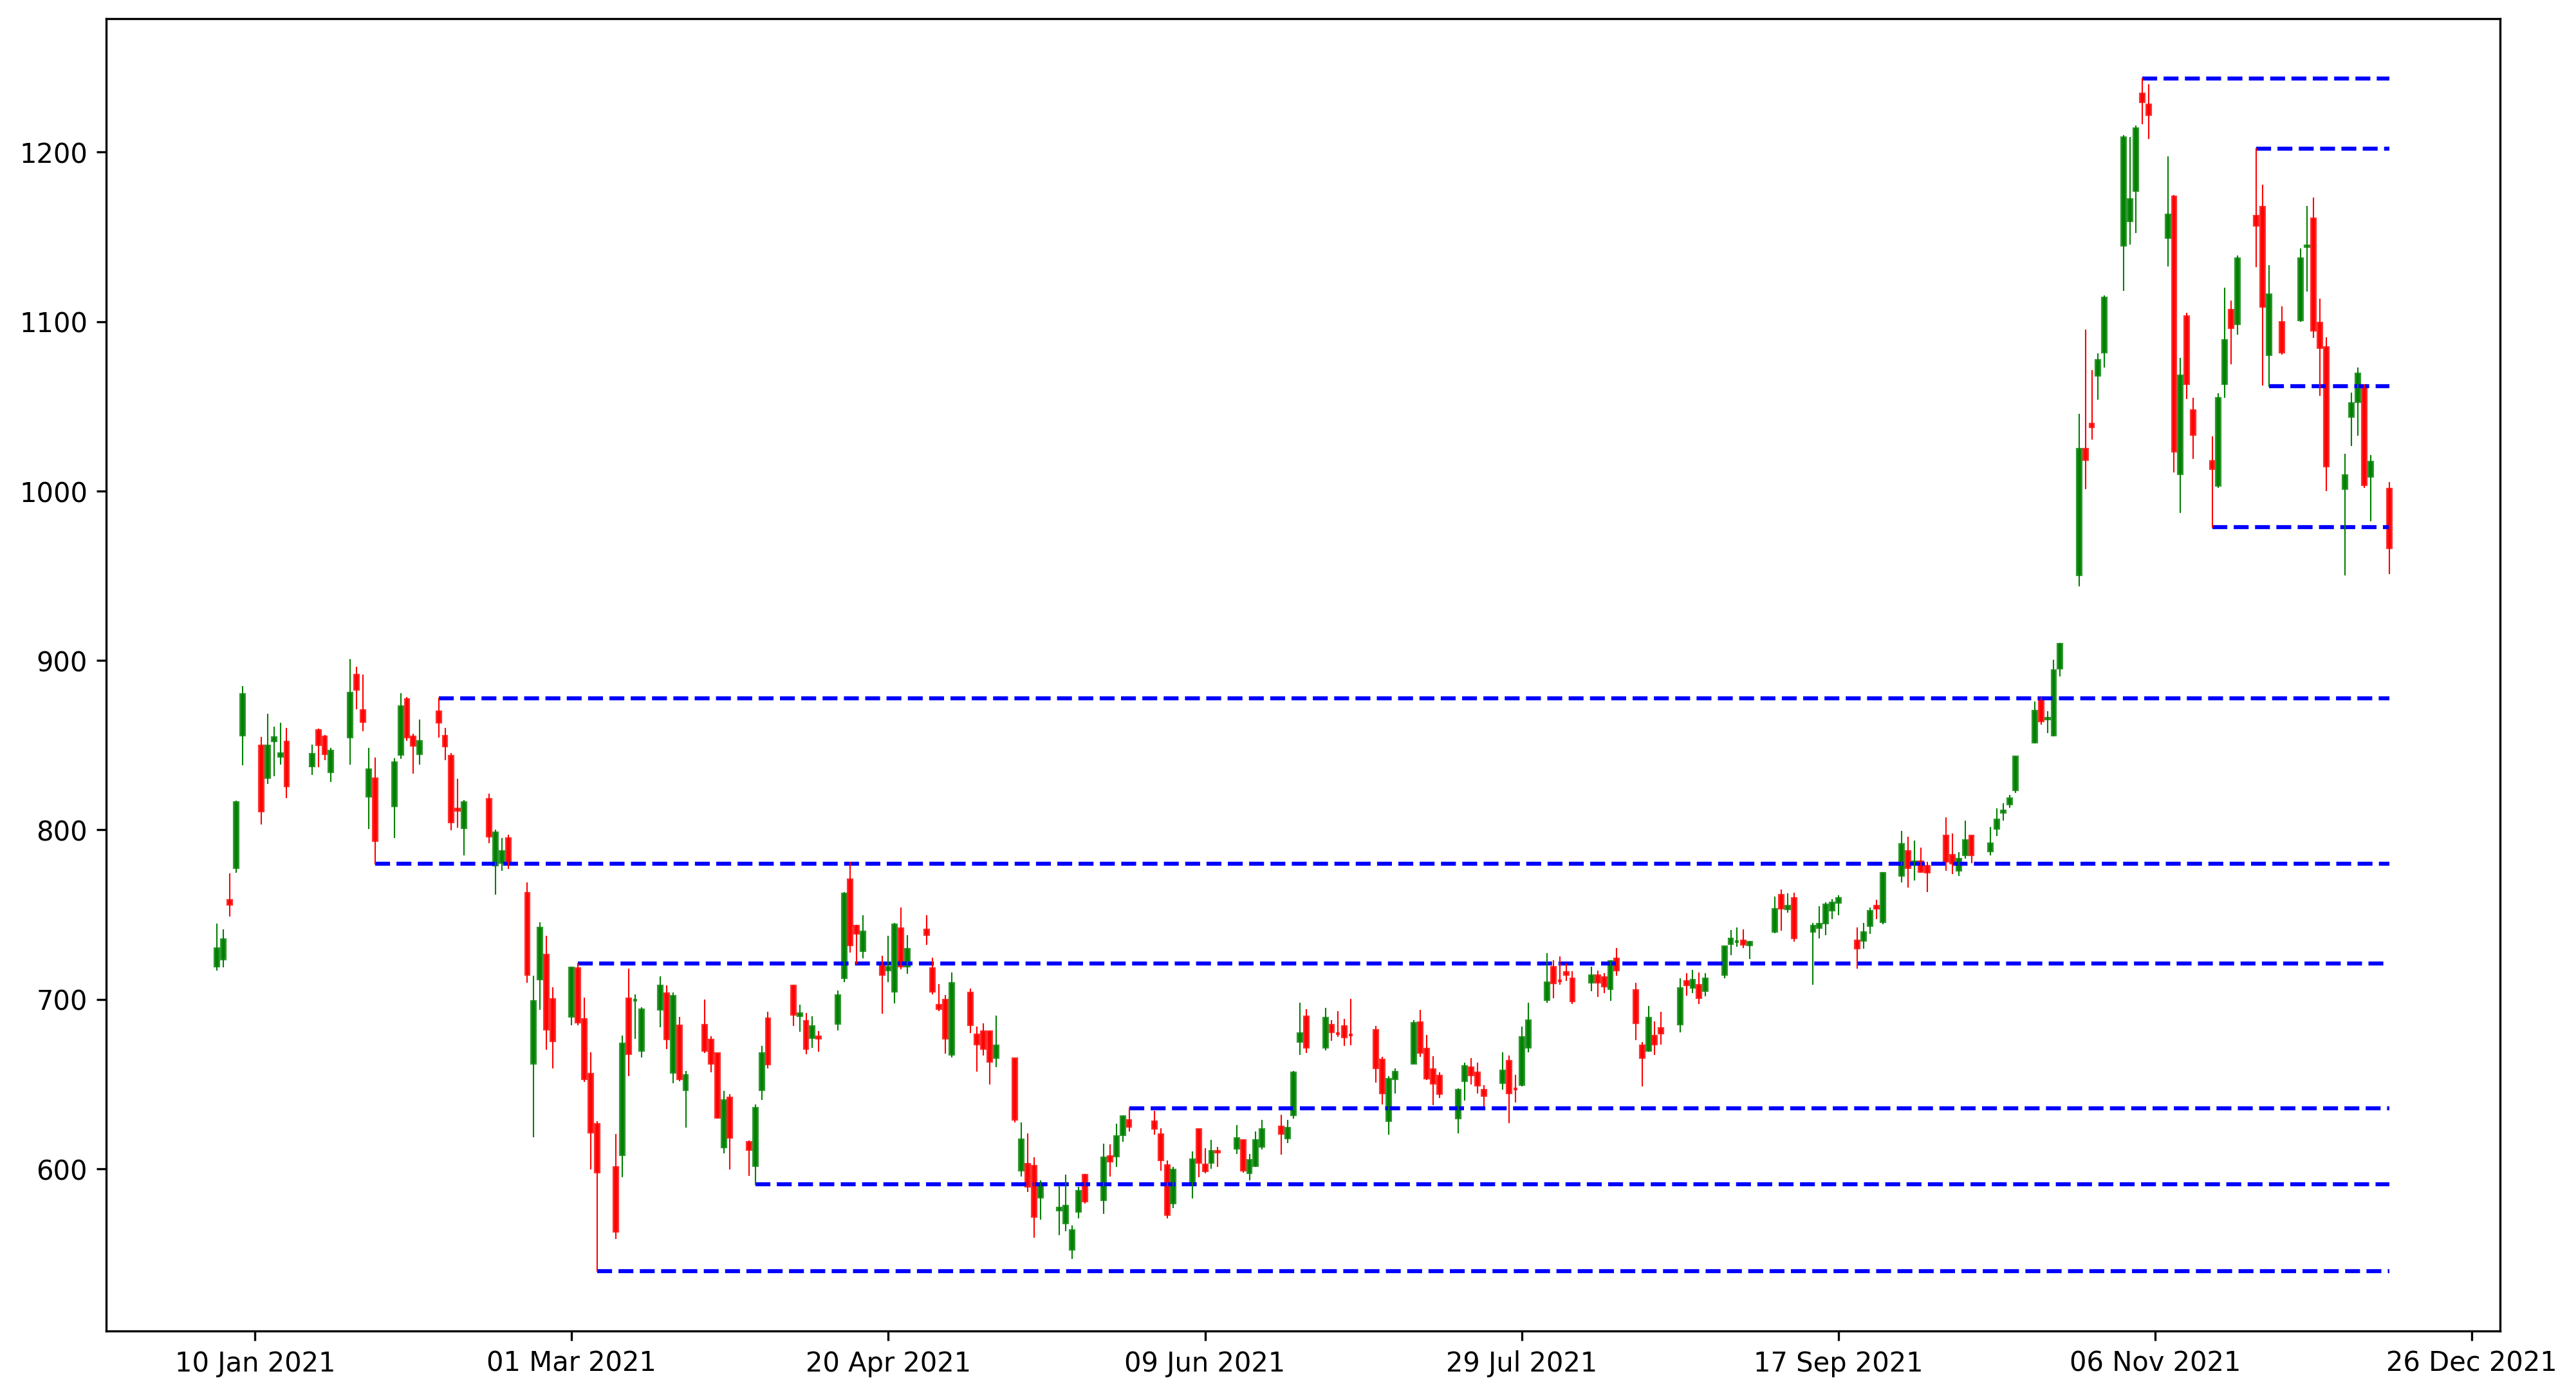

In [13]:
symbol = 'TSLA'
df = get_stock_price(symbol)
levels = []
for i in range(2,len(df)-2):
  if is_support(df,i):
    l = df['Low'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))
  elif is_resistance(df,i):
    l = df['High'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))

plot_all(levels, df)

In [17]:
options_df = options_chain(symbol)
column = options_df["openInterest"]
max_index = column.idxmax()
options_df.iloc[max_index]

contractSymbol       TSLA220617P00003000
strike                                 3
bid                                    0
ask                                 0.03
volume                               400
openInterest                       17195
impliedVolatility                 2.5625
inTheMoney                         False
expirationDate                2022-06-17
CALL                               False
mark                               0.015
Name: 4435, dtype: object